# QV Approach for solving k-maximum visibility

In [1]:
# [TODO]: Add 10000 scaling properly
# (are) Overlapping obstacles causing an issue ?

In [37]:
import math
import fiona
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gp

from random import random
from queue import PriorityQueue
from shapely.ops import nearest_points
from shapely.geometry import Polygon,Point, MultiPoint, box
from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw

%matplotlib inline

np.random.seed(2)


## skgeom functions

In [38]:
def asPoint(point2):
    return Point(point2.bbox().xmax(),point2.bbox().ymax())

In [39]:
def asPoint2(point):
    return Point2(point.x,point.y)

In [40]:
def intersectHelper(segment, node:list):
    '''
        Intersection helper to find the same between a halfedge and a node (list of segments).
        @returns-> List of segments
    '''
    ret = []
    part1 = Segment2(segment.source().point(), segment.target().point())

    for segs in node:
        isx = intersection(part1, segs)
        if type(isx) == Segment2:
            ret.append(isx)

    return ret

In [41]:
def updateVisibility(queryPoint:Point2, Target_:list, outer:list, visReg:list = [],node = []):
    '''
        Plain visible region calculation
        @args:
            query point:Point2  --> query point
            Target_:[segments] --> Target node
            arrgmtangement:Arrangement --> The arrangement (see docs)
            visReg:[segments] --> list of visible segments (after first pass) 
        @returns:
            visible region:[segments]
    '''
    arrgmt = arrangement.Arrangement()

    for bounds in outer:
        arrgmt.insert(bounds)
    for bounds in Target_:
        arrgmt.insert(bounds)

    # arrgmt = arrgmtange

    if(node != []):
        nodeVx = node.exterior.coords
        nodeBuilder = []

        # [TODO] Build a duplicate checker since skgeom throws an error
        for i in range(len(nodeVx)-1):
            nodeBuilder.append(Segment2(Point2(nodeVx[i][0],nodeVx[i][1]), Point2(nodeVx[i+1][0],nodeVx[i+1][1])))

        for bounds in nodeBuilder:
            arrgmt.insert(bounds)


    vs = RotationalSweepVisibility(arrgmt)
    face = arrgmt.find(queryPoint)
    vx = vs.compute_visibility(queryPoint, face)
    vis = []

    # Draw visibility --optional, should be removed in prod
    
    # for he in arrgmt.halfedges:
    #     draw.draw(he.curve(), visible_point=False)
    # draw.draw(queryPoint, color='magenta')

    if(visReg == []):
        for v in vx.halfedges:
            vis+=intersectHelper(v,Target_)
    else:
        # print("else!")
        for v in vx.halfedges:
            vis+=intersectHelper(v,visReg)

    ret = []
    [ret.append(x) for x in vis if x not in ret]
    # for v in ret:
    #     draw.draw(v, color='red', visible_point=False)
    return ret

In [42]:
gdf = gp.read_file("datasets/obstacles2000.gpkg")
qpGdf = gp.read_file("datasets/querypoints2000.gpkg")


In [43]:
'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = qpGdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxy+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])

In [44]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''

# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].simplify(0.5) 
# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.06)
print(gdf.shape)

(503, 143)


In [45]:
'''
    Building TARGET.
'''
# Random Target
Target = gdf.sample(n=1)

# Specific Target
# Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.
print(Target)

gdf.drop(Target.index, inplace=True)

     element_type      osmid addr:state building    ele gnis:county_name  \
3335          way  426247627       None    house  133.0             None   

     gnis:feature_id gnis:import_uuid gnis:reviewed  name  ...  \
3335            None             None          None  None  ...   

     building:levels:underground  ways  type   url building:height capacity  \
3335                        None  None  None  None            None     None   

     theatre:genre name:de                                           geometry  \
3335          None    None  POLYGON ((-118.26345 34.06553, -118.26350 34.0...   

                         centroid  
3335  POINT (-118.26346 34.06556)  

[1 rows x 143 columns]


<AxesSubplot:>

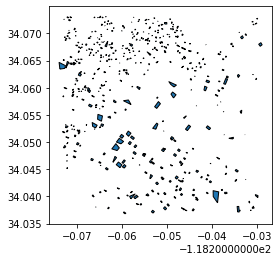

In [46]:
base = gdf.plot(edgecolor='black')
Target.plot(ax=base, color='red')

<AxesSubplot:>

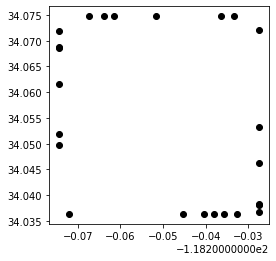

In [47]:
qpGdf.plot(color="black")

In [48]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

# [TODO] Build a duplicate checker since skgeom throws an error
for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

for bounds in targetBuilder:
    arr.insert(bounds)

targetPolyBuilder = []
for i in range(len(targetVx)-1):
    targetPolyBuilder.append(Point(targetVx[i][0]*10000,targetVx[i][1]*10000))

scaledTarget = Polygon(targetPolyBuilder)

In [49]:
# list(scaledTarget.exterior.coords)

In [50]:
# list(Boundary.exterior.coords)

In [51]:
# print(targetBuilder)

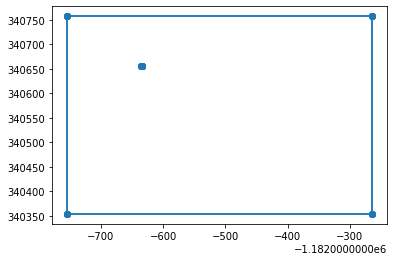

In [52]:
for he in arr.halfedges:
    draw.draw(he.curve())

In [53]:
rtree1 = gdf.sindex

In [54]:
print(len(rtree1.leaves()))
nodeSet = []
for rtn in rtree1.leaves():
    for rt in rtn[1]:
        nodeSet.append(rt)


8


In [55]:
print(len(nodeSet))

502


In [56]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        return ang_deg

In [57]:
def getLength(vrset:list, queryPoint:Point):
    '''
        Plain visible region calculation
        @args:
            visible region:[segments]
            query point:Point
        @returns:
            length:int
    '''
    lineA = [[queryPoint.x,queryPoint.y],[]]
    lineB = [[],[]]
    dist=0
    for vr in vrset:
        if(vr):
            # print(vr)
            src = asPoint(vr.source())
            tgt = asPoint(vr.target())
            start = [src.x,src.y]
            end = [tgt.x,tgt.y]
            lineA[1] = [(start[0]+end[0])/2,(start[1]+end[1])/2]
            lineB[0] = start
            lineB[1] = end
            angle = ang(lineA,lineB)
            dist+=(angle/90)*src.distance(tgt)
            dist = round(dist,6)
    # print(dist)
    return dist


In [58]:
def minDist(queryPoint:Point,node:Polygon):
    nPoints = nearest_points(queryPoint,node)
    return round(nPoints[0].distance(nPoints[1]),6)

In [59]:
def getScaledNode(node):

    if(node.area == 0.0):
        return Point(node.x*10000,node.y*10000)

    vertices = node.exterior.coords
    scaledVx = []
    for vertex in vertices:
        scaledVx.append((vertex[0]*10000,vertex[1]*10000))
    scaledNode = Polygon(scaledVx)
    return scaledNode

In [60]:
def getScaledPoint(index, qdf):
    return Point(qdf['geometry'][index].x*10000,qdf['geometry'][index].y*10000)

In [61]:
def buildVRPolygons(vis:list, queryPoint:Point):
    '''
        Return set of VR Polygons
        @args:
            visible region:[segments]
            query point:Point
        @returns:
            vrSet:int
    '''
    vrSet = []
    for seg in vis:
        VRvertices = [queryPoint]
        if(seg.source() not in VRvertices):
            VRvertices.append((seg.source().x(),seg.source().y()))
        if(seg.target() not in VRvertices):
            VRvertices.append((seg.target().x(),seg.target().y()))
        vrSet.append(Polygon(VRvertices))
    
    return vrSet

In [62]:
def insideVisibleRegion(visibleRegionSet:list, node:Polygon):
    '''
        Test if VR and (skgeom)polygon intersect
            @args:
                visibilityRegionSet:[Polygons] --> VR from query point
                node:[segments] --> obstacle
            @returns:
                bool --> True when polygon and VR intersect, False o.w.
    '''
    for vrPolygon in visibleRegionSet:
        intersection = node.boundary.intersection(vrPolygon.boundary)
        # print(intersection)
        if isinstance(intersection,MultiPoint) or isinstance(intersection,Point):
            return True
    
    return False

In [63]:
def enqueue(x:{},key,value):
    '''
        Enqueue in priority queue
        @args:
            priority queue:dict
            key
            value
        @returns:
            priority queue:dict
    '''
    x[key]=-1*value
    return dict(sorted(x.items(), key=lambda item: item[1]))

def dequeue(x:{}):
    '''
        Dequeue last element from priority queue
        @args:
            priority queue:dict
        @returns:
            tuple(key,value)
    '''
    if len(x) != 0:
        element = x.popitem()
    else:
        element = (-1,-1)
    return element

In [64]:
def getImpactRatio(vrOld:list, vrNew:list, queryPoint:Point):
    lengthOld = getLength(vrOld,queryPoint)
    lengthNew = getLength(vrNew,queryPoint)

    return (1 - round(lengthNew/lengthOld,6))

In [65]:
def QVkMaximumVisibility(T,outer,Q,k, gdf):
    '''
        Main algorithm from MV paper: Query Centric Distance based approach
    '''
    kNew = k
    L = []
    L_vis = []
    L_vrPoly = []
    VQ = {}
    LO = [{} for _ in range(len(Q.index))]
    CO = set()
    vrset = np.empty(len(Q.index),dtype=object)
    vrPoly = np.empty(len(Q.index),dtype=object)
    end = False
    cont = True
    node = 0 # ?
    for ix in Q.index:
        queryPoint = getScaledPoint(ix,Q)
        if(Boundary.contains(queryPoint)== True):
            # UpdateVisibility
            vrset[ix] = updateVisibility(asPoint2(queryPoint),T,outer)
            vrPoly[ix] = buildVRPolygons(vrset[ix],queryPoint)
            # Enqueue in VQ
            val = getLength(vrset[ix], queryPoint)
            VQ = enqueue(VQ, Q['id'][ix], -1*val)
    print("Phase 1 OK!")
    # 1.11
    for nodeList in rtree1.leaves():
        print('1')
        if(end == True):
            break
        # Enqueue all obs
        for nodeId in nodeSet:
            # 1.12
            if(nodeId not in CO):
                node = getScaledNode(gdf.iloc[nodeId].geometry)
                for ix in Q.index:
                    queryPoint = getScaledPoint(ix,Q)
                    if(Boundary.contains(queryPoint)== True):
                        if(insideVisibleRegion(vrPoly[ix],node) == True):
                            vrCompare = updateVisibility(asPoint2(queryPoint),T,outer,vrset[ix],node)
                            impact = getImpactRatio(vrset[ix],vrCompare,queryPoint)
                            LO[ix]=enqueue(LO[ix],nodeId,impact)
                # CO.add(nodeId)
    # -----------------------------------------------------------------
        cont = True # Align with: if node not in CO
        while (cont == True):
            current_best,_ = dequeue(VQ) # current_best = ID of best query point
            nodeId,_ = dequeue(LO[current_best])
            if (nodeId == -1):
                L.append(current_best)
                qP = getScaledPoint(current_best,Q)
                val = getLength(vrset[current_best], qP)
                L_vis.append(val)
                L_vrPoly.append(vrPoly[current_best])
                k = k-1
                # print(k,"kdecreased!")
                if (k<=0):
                    end = True
                    cont = False
                # if(len(L) == kNew):
                #     return L, L_vis, L_vrPoly, vrPoly

            elif (nodeId not in CO):
                node = getScaledNode(gdf.iloc[nodeId].geometry)
                if(insideVisibleRegion(vrPoly[current_best],node) == True):
                    queryPoint = getScaledPoint(current_best,Q)
                    vrset[current_best] = updateVisibility(asPoint2(queryPoint),T,outer,vrset[current_best],node)
                    vrPoly[current_best] = buildVRPolygons(vrset[current_best],queryPoint)
                    for qp in VQ.keys():
                        index = qp
                        if (insideVisibleRegion(vrPoly[index],node) == True):
                            queryPoint_i = getScaledPoint(index,Q)
                            vrset[index] = updateVisibility(asPoint2(queryPoint_i),T,outer,vrset[index],node)
                            vrPoly[index] = buildVRPolygons(vrset[index],queryPoint_i)
                val = getLength(vrset[current_best], queryPoint)
                VQ = enqueue(VQ, Q['id'][current_best], -1*val)
                # CO.add(nodeId)
            else:
                val = getLength(vrset[current_best], queryPoint)
                VQ = enqueue(VQ, Q['id'][current_best], -1*val)
                cont = False
    return L, L_vis, L_vrPoly, vrPoly
    # -----------------END--------------------


In [66]:
ans, ans_vis, ans_vrPoly, vrPolygons = QVkMaximumVisibility(targetBuilder,outer, qpGdf, 5, gdf)
print(list(ans))
print(list(ans_vis))

Phase 1 OK!
1
1
[17, 4, 0, 23, 1]
[0.711538, 0.523827, 0.438958, 0.352417, 0.053039]


In [67]:
# for ix in qpGdf.index:
#         print(ix)
#         print(qpGdf['geometry'][ix])

In [68]:
'''
    Plotting routine
    Plot scaled Target: Polygon
    Plot scaled Obstacles: Polygons
    Plot scaled Query Points: Points
    Plot retrieved Query Points: Points
    Plot query point visibility polygons: Polygons (already scaled)

    Append everything to a geoseries and plot it.
'''

Tlist = []
Tlist.append(scaledTarget)
Obslist = []
for nodeList in rtree1.leaves():
    for nodeId in nodeList[1]:
        Obslist.append(getScaledNode(gdf.iloc[nodeId].geometry))
QPlist = []
for ix in qpGdf.index:
    QPlist.append(getScaledPoint(ix,qpGdf))
VRlist = []
for ix1 in vrPolygons:
    for ix2 in ix1:
        VRlist.append(ix2)
ansVRlist = []
for ix1 in ans_vrPoly:
    for ix2 in ix1:
        ansVRlist.append(ix2)
Alist = []
for ix in ans:
    Alist.append(getScaledPoint(ix,qpGdf))


In [69]:
import matplotlib.pyplot as plt

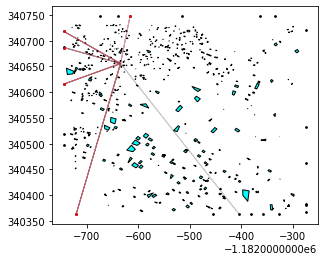

In [70]:
Tplot = gp.GeoSeries(Tlist)
QPplot = gp.GeoSeries(QPlist)
Obsplot = gp.GeoSeries(Obslist)
VRplot = gp.GeoSeries(VRlist)
ansVRplot = gp.GeoSeries(ansVRlist)
Aplot = gp.GeoSeries(Alist)

base = VRplot.plot(color='pink', edgecolor='black',alpha=0.2)
base2 = QPplot.plot(ax = base, color='black',markersize=3)
base3 = Obsplot.plot(ax = base2, color='cyan', edgecolor='black')
base4 = Tplot.plot(ax = base3, color='orange')
base5 = Aplot.plot(ax = base4, color='red',markersize=3)
base6 = ansVRplot.plot(ax = base5, color='lime', edgecolor='crimson',alpha=0.25)